In [61]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [62]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [63]:
Patient2 = sc.read(inpath+"Patient2.h5ad")
Patient4 = sc.read(inpath+"Patient4.h5ad")
Patient5 = sc.read(inpath+"Patient5.h5ad")
Patient6 = sc.read(inpath+"Patient6.h5ad")


In [64]:
Patient4.X.A.min()

0.0

# Read Metadata

In [65]:
metadata = pd.read_excel('Metadata2.xlsx')

In [66]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

# Fix Metadata 

In [67]:
def fixmeta(metadata,sample,adata):
    tmp1 = metadata.loc[metadata['SampleID'] == sample].loc[metadata.loc[metadata['SampleID'] == sample].index.repeat(adata.shape[0])]
    tmp1.reset_index(drop=True,inplace=True)
    tmp1.set_index( str(sample)+"_"  + tmp1.index.astype(str),inplace=True) 
    adata.obs = tmp1
    return adata

In [68]:
Patient2 = fixmeta(metadata,2,Patient2)
Patient4 = fixmeta(metadata,4,Patient4)
Patient5 = fixmeta(metadata,5,Patient5)
Patient6 = fixmeta(metadata,6,Patient6)

# Concatenate 

In [69]:
Patient2.var_names_make_unique()
Patient4.var_names_make_unique()
Patient5.var_names_make_unique()
Patient6.var_names_make_unique()

In [70]:
adata = Patient2.concatenate(Patient4,Patient5,Patient6,
                         index_unique=None)

In [71]:
del(Patient2,Patient4,Patient5,Patient6)

In [72]:
print(adata.obs['SampleID'].value_counts())
adata

4    10504
6     2122
2     1651
5      266
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 14543 × 33538
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [73]:
adata.layers['raw'] = adata.X.A

# Calculate QC

In [74]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [75]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [76]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [77]:
adata

AnnData object with n_obs × n_vars = 14543 × 33538
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

In [78]:
adata.obs['SampleID'] = adata.obs['SampleID'].astype(str)

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


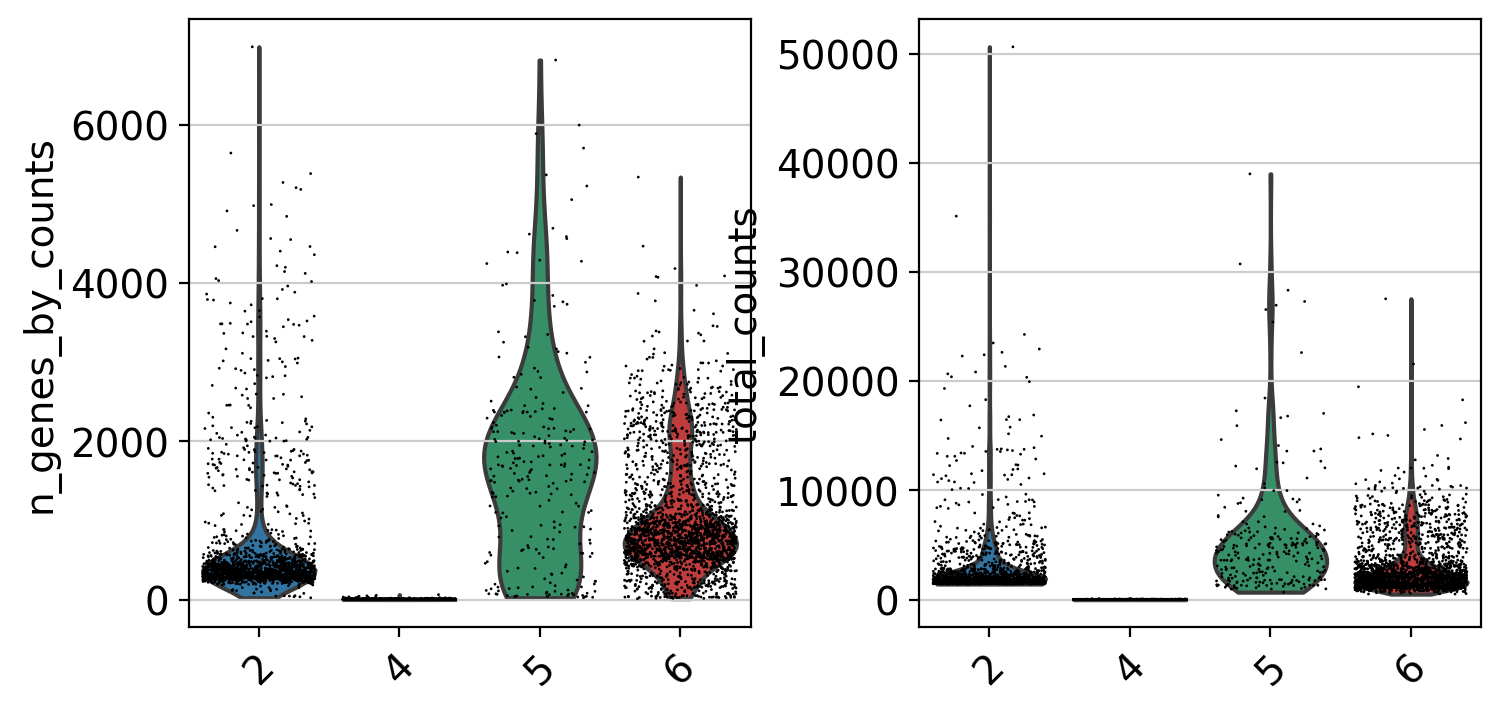

In [79]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

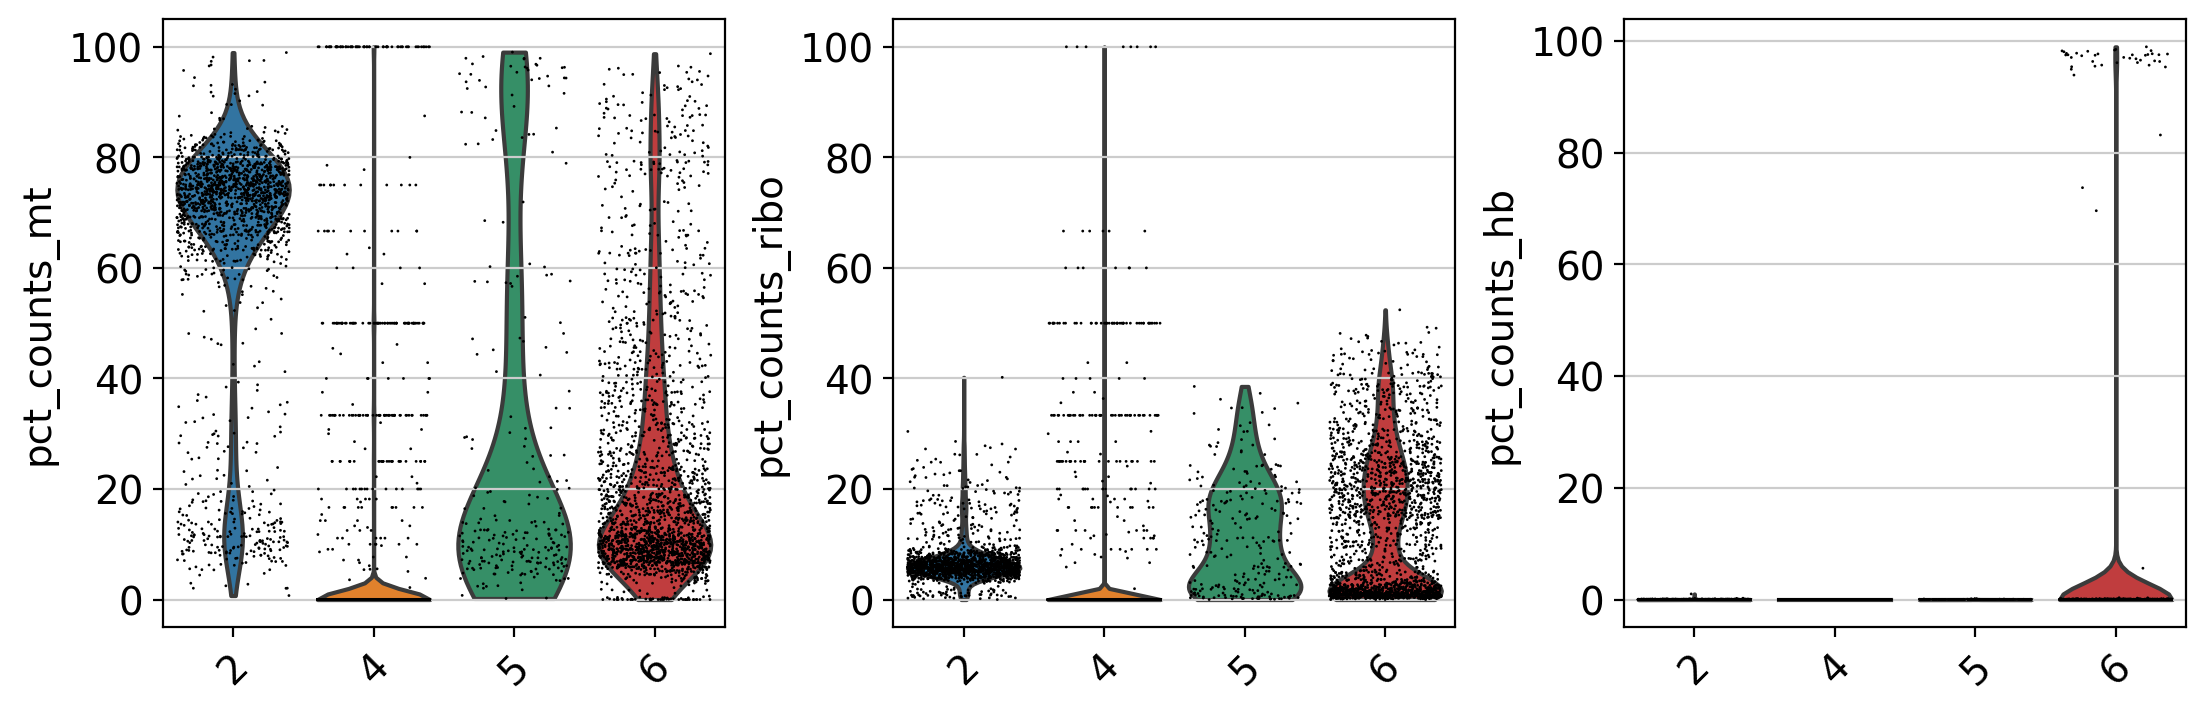

In [80]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

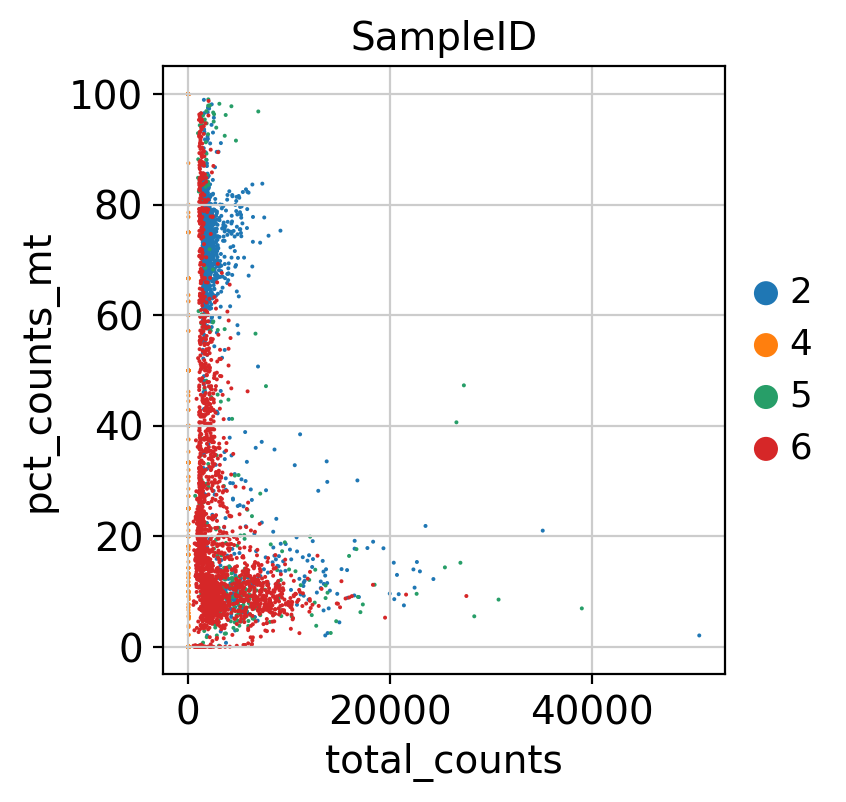

In [81]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [82]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

3848 18044


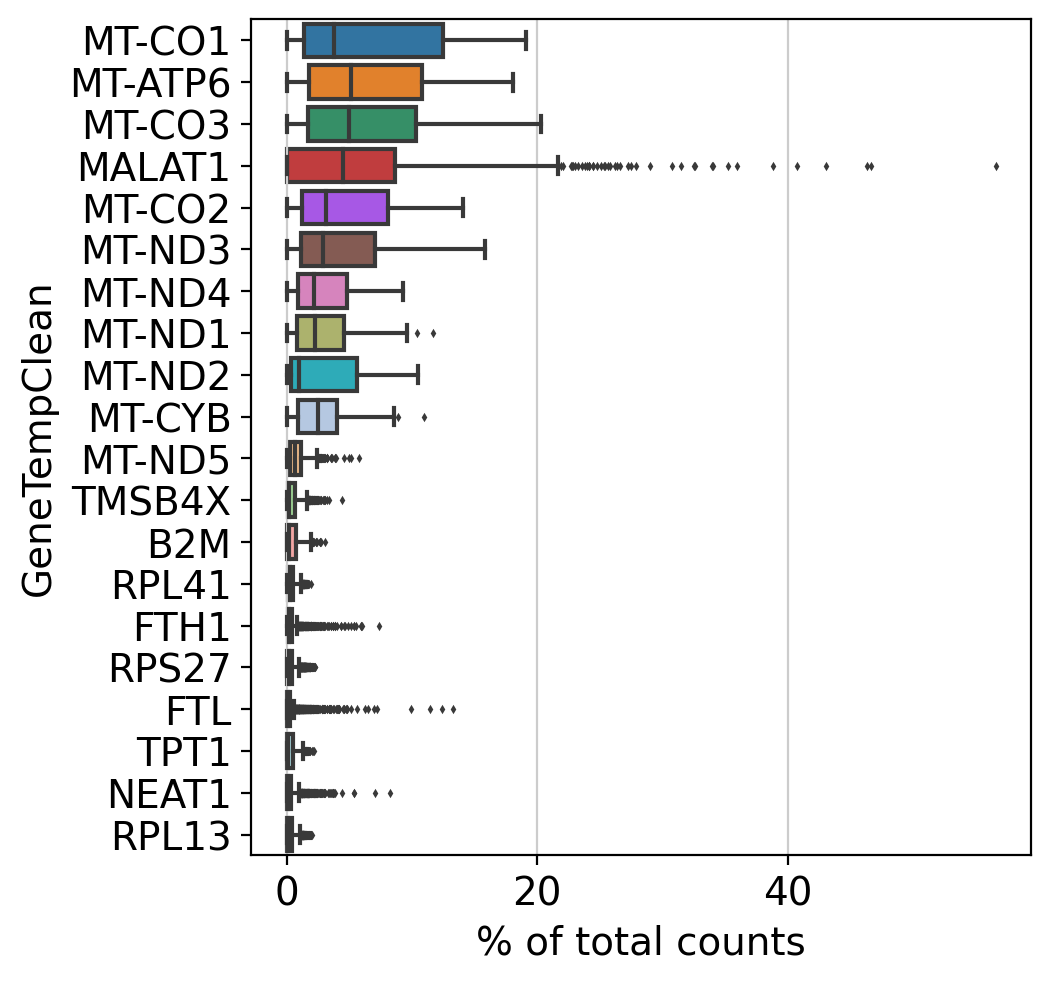

In [83]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [84]:
#adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
#adata = adata[adata.obs['pct_counts_ribo'] > 2, :]
#adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 3848


# Plot filtered QC

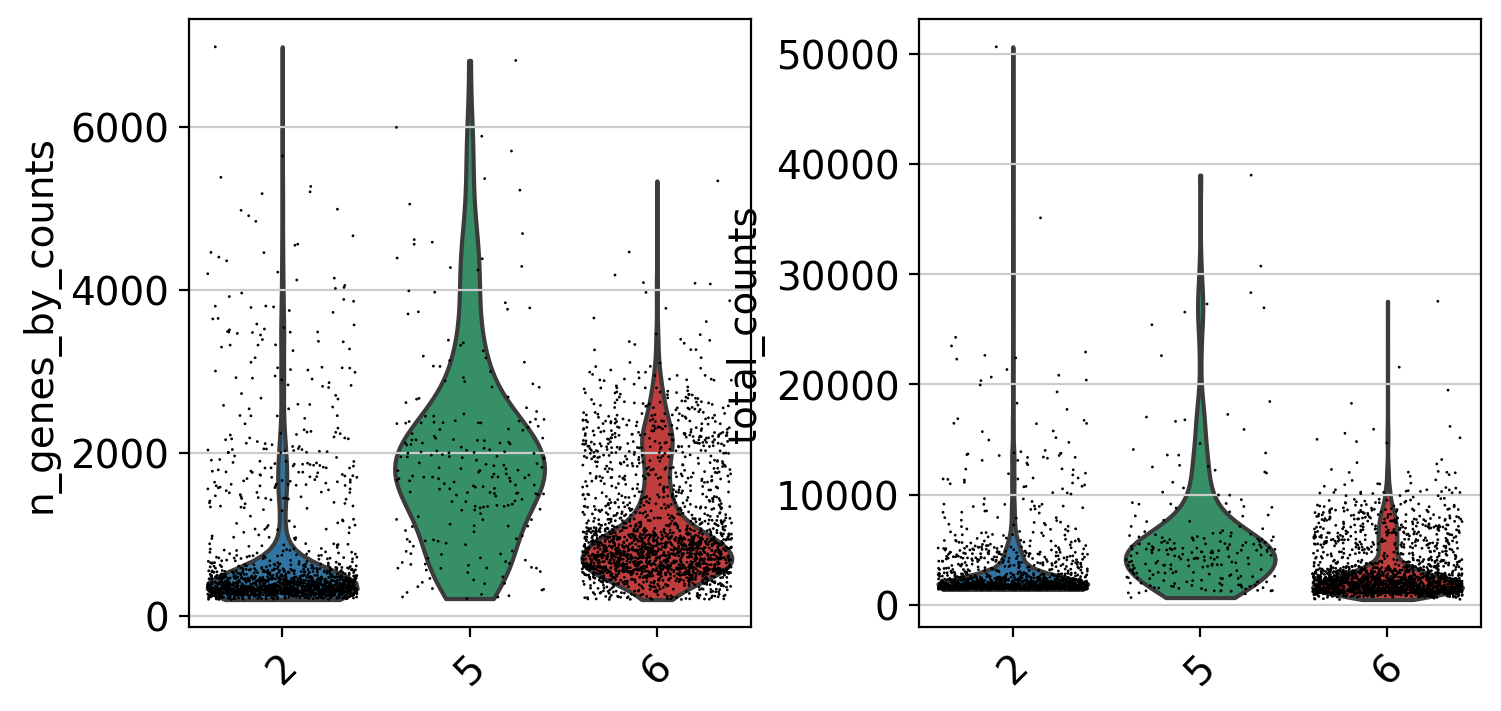

In [85]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

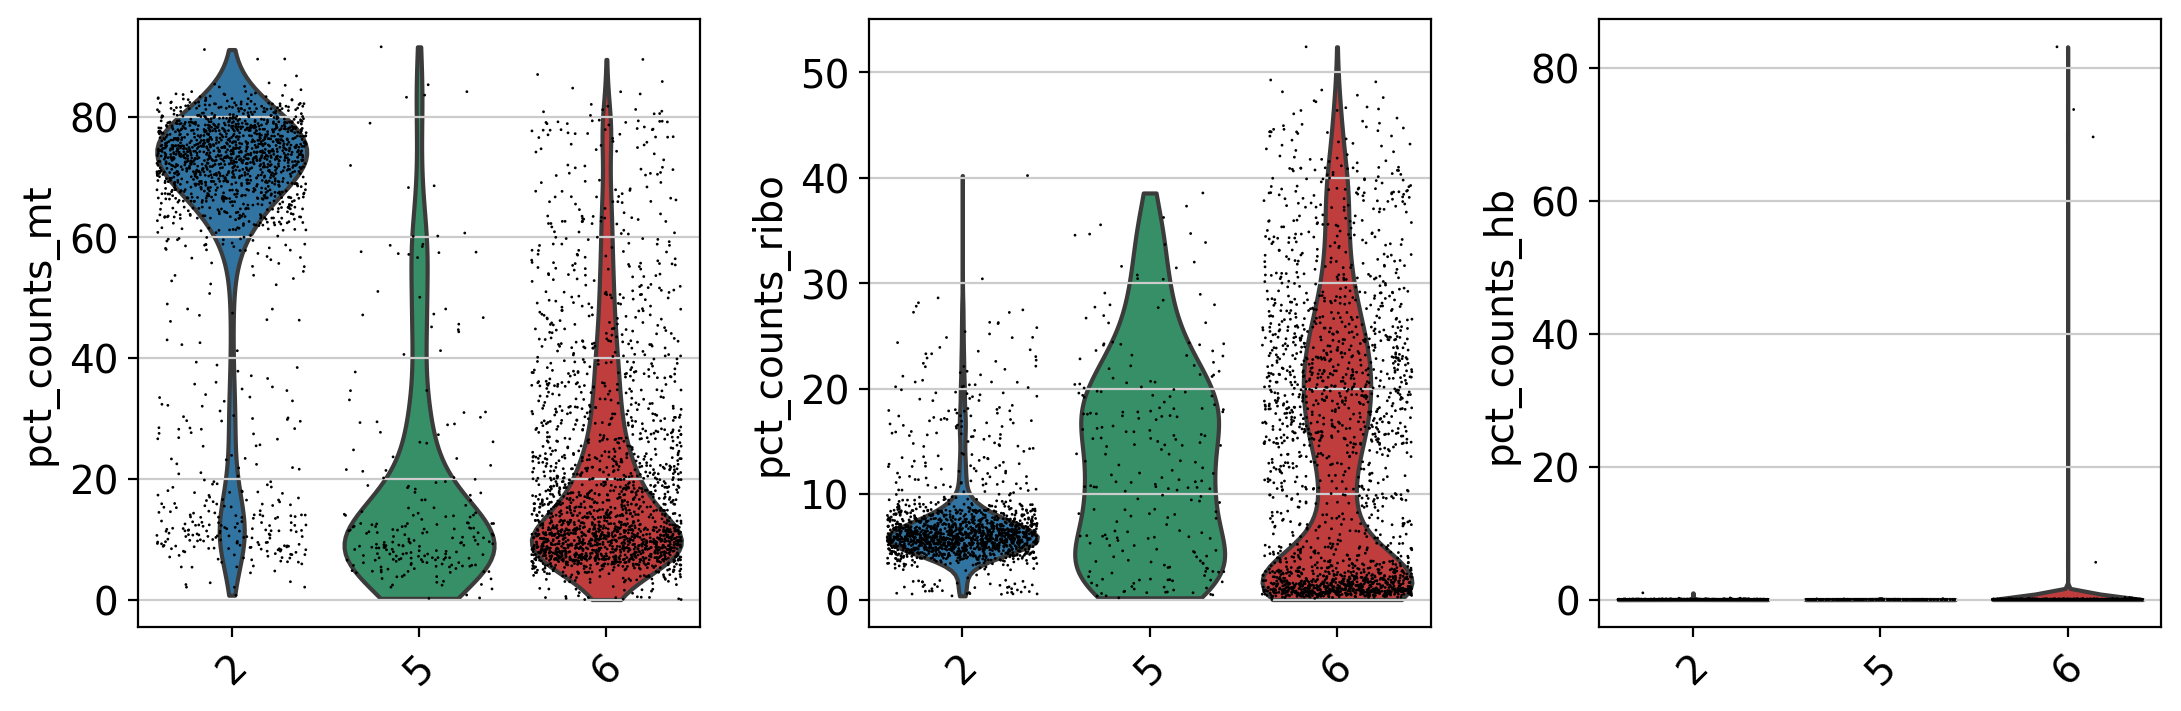

In [86]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [87]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [88]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [89]:
adata = adata[:, ~mito_gene_indicator]

In [90]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

3848 18031
3848 17927


# Calculate cell-cycle scores

In [91]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
90


In [92]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


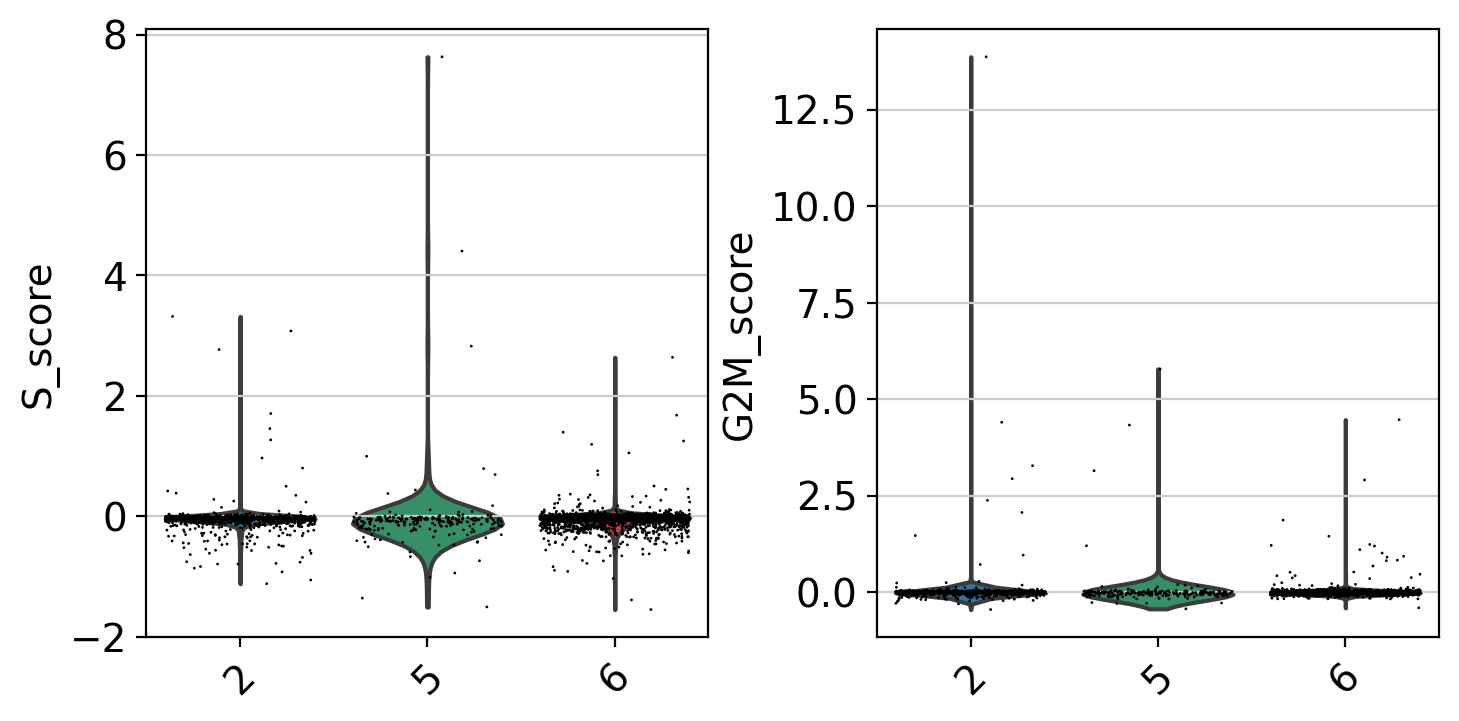

In [93]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 26.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.9%
Elapsed time: 2.2 seconds


9

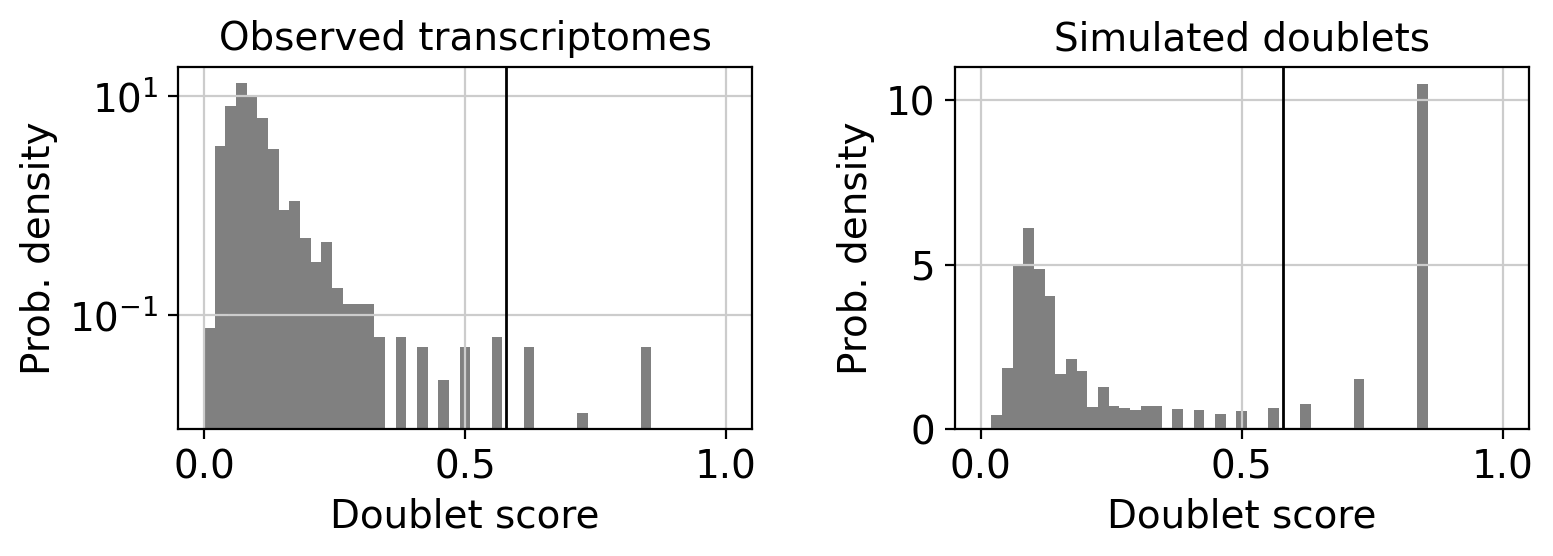

In [94]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [95]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


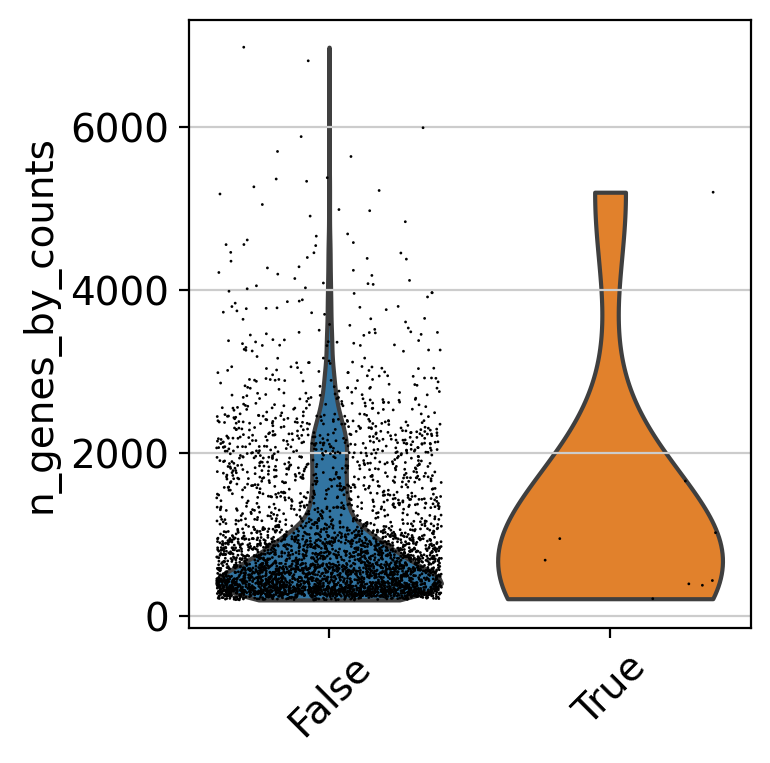

In [96]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [98]:
#adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [99]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# scale
#sc.pp.scale(adata)

# Celltypist classification

In [100]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [101]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [102]:
adata

AnnData object with n_obs × n_vars = 3848 × 17927
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [103]:
sce.pp.harmony_integrate(adata, key= 'SampleID')

2022-06-17 14:12:53,757 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-17 14:12:54,252 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-17 14:12:54,751 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations


In [104]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [105]:
sc.tl.umap(adata)

In [106]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [107]:
adata

AnnData object with n_obs × n_vars = 3848 × 17927
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [108]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 14
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/14]: Immune_All_Low.pkl
💾 Downloading model [2/14]: Immune_All_High.pkl
💾 Downloading model [3/14]: Immune_All_PIP.pkl
💾 Downloading model [4/14]: Immune_All_AddPIP.pkl
💾 Downloading model [5/14]: Adult_Mouse_Gut.pkl
💾 Downloading model [6/14]: COVID19_Immune_Landscape.pkl
💾 Downloading model [7/14]: Cells_Fetal_Lung.pkl
💾 Downloading model [8/14]: Cells_Intestinal_Tract.pkl
💾 Downloading model [9/14]: Cells_Lung_Airway.pkl
💾 Downloading model [10/14]: Developing_Mouse_Brain.pkl
💾 Downloading model [11/14]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [12/14]: Human_Lung_Atlas.pkl
💾 Downloading model [13/14]: Nuclei_Lung_Airway.pkl
💾 Downloading model [14/14]: Pan_Fetal_Human.pkl


In [109]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [111]:
adata.X =  adata.layers['raw']

In [113]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [115]:
sc.pp.log1p(adata)

In [116]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 3848 cells and 17927 genes
🔗 Matching reference genes in the model
🧬 2594 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [117]:
#adata.obs['CellCount']= adata.obs['CellCount'].astype(int)

In [118]:
adata.obs['Sample'].value_counts()

Patient84    2004
Patient81    1616
Patient83     228
Name: Sample, dtype: int64

In [119]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_N_GSE147275_PMID34138753.h5ad")

In [120]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 3848 × 17927
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    la

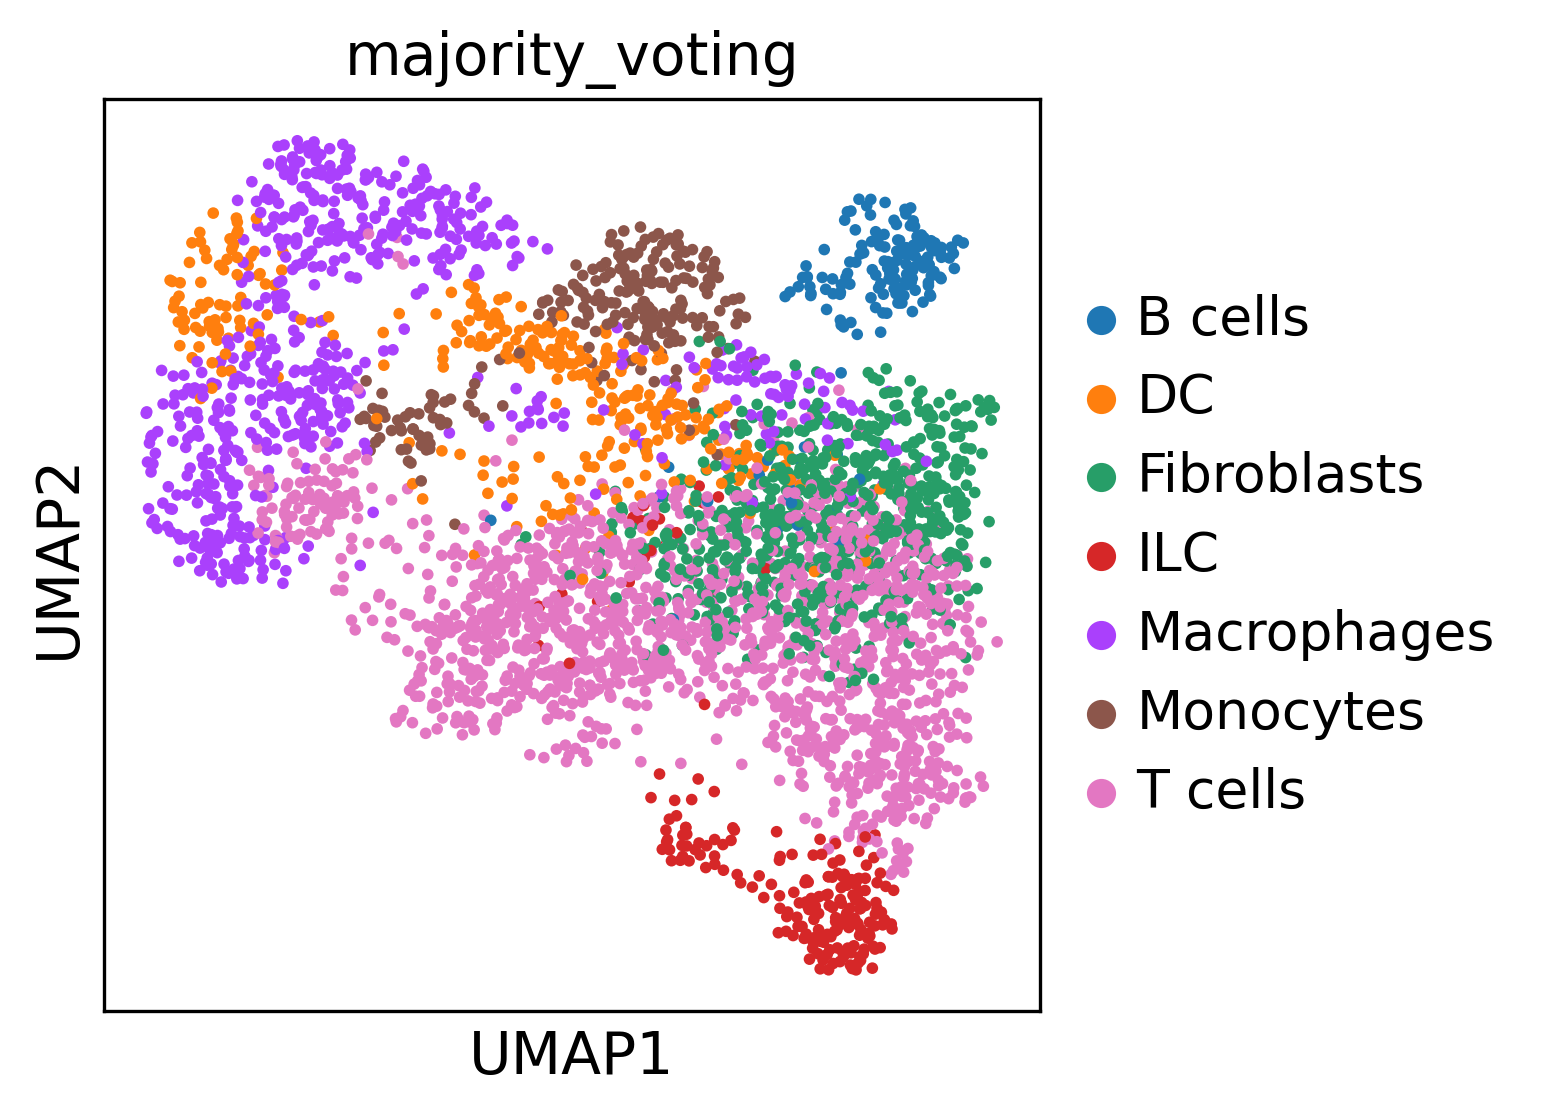

In [121]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [122]:
adata = adata[:, adata.var.highly_variable]

In [123]:
markers = dc.get_resource('PanglaoDB')
markers

label,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.0,0.00439422,True,0.00331126,0.0204803,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.00503937,True,0.903226,0.0124084,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.0,0.00823306,True,0.225806,0.0137585,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8473,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8474,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8475,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [124]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [125]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
1,CTRB1,True,Acinar cells,Endoderm,True,1.0,0.000628931,True,0.957143,0.0159201,9606,Pancreas,0.017
2,KLK1,True,Acinar cells,Endoderm,True,0.833333,0.00503145,True,0.314286,0.0128263,9606,Pancreas,0.013
5,KLK1,True,Principal cells,Mesoderm,True,0.0,0.00814536,True,0.285714,0.0140583,9606,Kidney,0.013
7,KLK1,True,Plasmacytoid dendritic cells,Mesoderm,True,0.0,0.00820189,True,1.0,0.0129136,9606,Immune system,0.013
8,KLK1,True,Endothelial cells,Mesoderm,True,0.0,0.00841969,True,0.0,0.0149153,9606,Vasculature,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,SLC14A1,True,Urothelial cells,Mesoderm,True,0.0,0.0181704,True,0.0,0.0,9606,Urinary bladder,0.008
8473,UPK3A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8474,UPK1A,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0
8475,UPK2,True,Urothelial cells,Mesoderm,True,0.0,0.0,True,0.0,0.0,9606,Urinary bladder,0.0


In [126]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

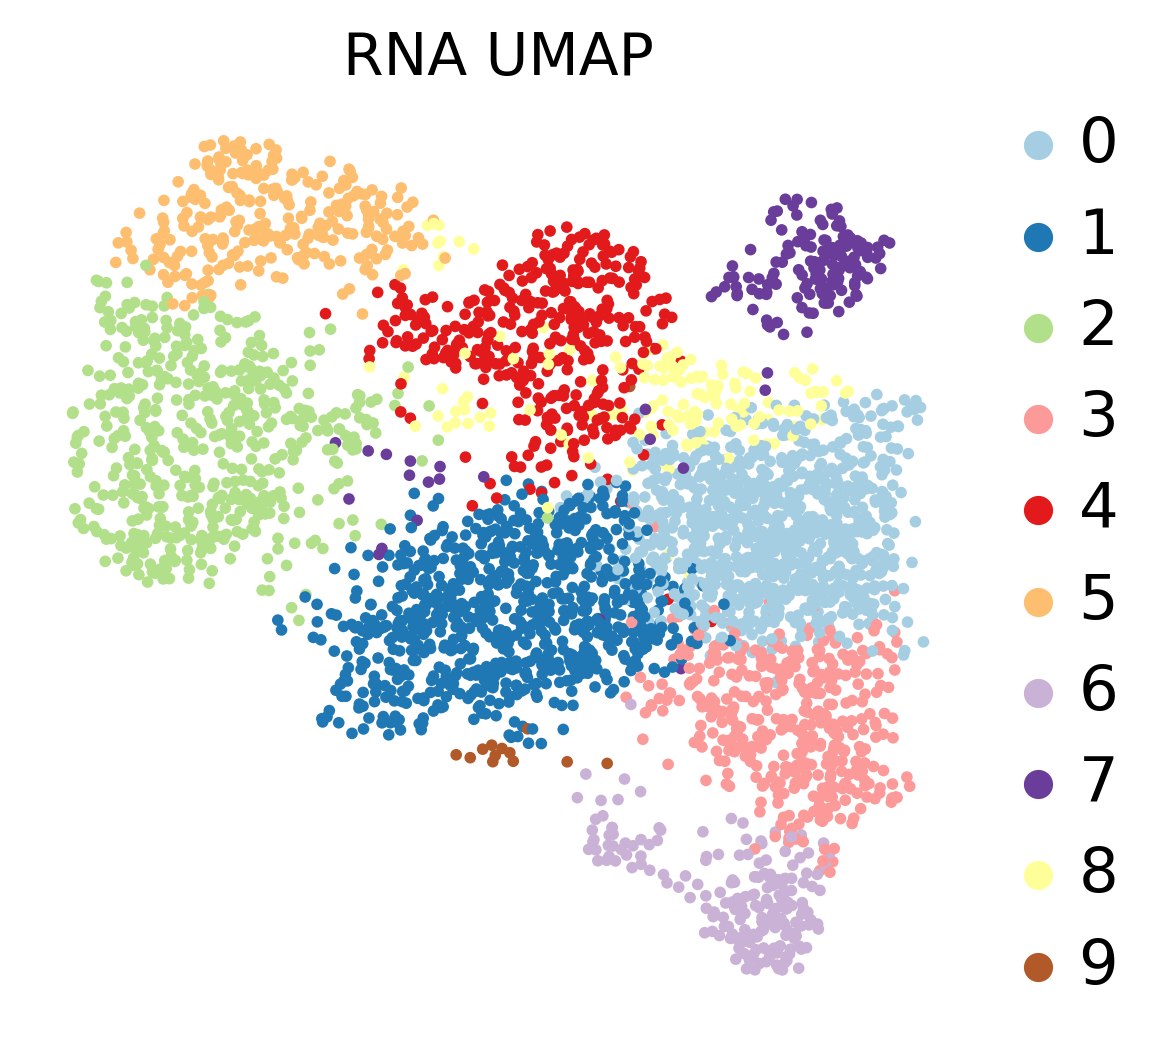

In [127]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [128]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 3848 samples and 5132 targets for 102 sources.


100%|██████████| 3848/3848 [00:01<00:00, 2751.84it/s]


In [129]:
adata.obsm['ora_estimate']

source,Acinar cells,Adipocytes,Adrenergic neurons,Alpha cells,Astrocytes,B cells,B cells memory,B cells naive,Basal cells,Basophils,...,Satellite cells,Satellite glial cells,Schwann cells,Sertoli cells,Smooth muscle cells,T cells,T helper cells,Tanycytes,Taste receptor cells,Tuft cells
2_0,-0.000000,-0.000000,-0.0,-0.0,1.835647,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.958997,0.877324,2.458865,0.728184,-0.000000,-0.000000,-0.000000,0.842264,-0.000000,-0.000000
2_1,-0.000000,-0.000000,-0.0,-0.0,1.835647,0.915981,-0.000000,0.728184,-0.000000,0.605992,...,-0.000000,0.877324,2.458865,1.756238,0.530313,0.842264,-0.000000,0.842264,-0.000000,-0.000000
2_2,1.126829,1.274073,-0.0,-0.0,2.771496,0.915981,-0.000000,0.728184,-0.000000,2.569340,...,0.958997,-0.000000,2.458865,2.983968,-0.000000,-0.000000,-0.000000,-0.000000,1.203246,-0.000000
2_3,-0.000000,-0.000000,-0.0,-0.0,1.835647,0.915981,-0.000000,0.728184,1.419547,1.493666,...,-0.000000,-0.000000,0.573526,1.756238,1.330077,0.842264,-0.000000,0.842264,-0.000000,-0.000000
2_4,-0.000000,1.274073,-0.0,-0.0,3.813786,0.915981,0.810226,0.728184,-0.000000,1.493666,...,0.958997,-0.000000,0.573526,1.756238,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6_2116,1.126829,-0.000000,-0.0,-0.0,1.029893,-0.000000,-0.000000,0.728184,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,0.728184,1.330077,-0.000000,-0.000000,-0.000000,-0.000000,1.062642
6_2117,-0.000000,-0.000000,-0.0,-0.0,1.029893,0.915981,-0.000000,0.728184,-0.000000,0.605992,...,-0.000000,-0.000000,0.573526,1.756238,-0.000000,8.434292,1.419547,-0.000000,-0.000000,-0.000000
6_2119,1.126829,1.274073,-0.0,-0.0,0.393411,-0.000000,-0.000000,-0.000000,-0.000000,0.605992,...,0.958997,-0.000000,-0.000000,0.728184,0.530313,-0.000000,-0.000000,0.842264,-0.000000,-0.000000
6_2120,1.126829,1.274073,-0.0,-0.0,-0.000000,-0.000000,-0.000000,0.728184,-0.000000,-0.000000,...,-0.000000,-0.000000,0.573526,0.728184,1.330077,-0.000000,-0.000000,-0.000000,-0.000000,1.062642


In [130]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Adrenergic neurons', 'Alpha cells',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive',
       'Basal cells', 'Basophils',
       ...
       'Satellite cells', 'Satellite glial cells', 'Schwann cells',
       'Sertoli cells', 'Smooth muscle cells', 'T cells', 'T helper cells',
       'Tanycytes', 'Taste receptor cells', 'Tuft cells'],
      dtype='object', name='source', length=102)

In [131]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 3848 × 102
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [132]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

,B cells,B cells memory,B cells naive,Dendritic cells,Gamma delta T cells,Kupffer cells,Macrophages,Microglia,Monocytes,NK cells,Natural killer T cells,Neutrophils,T cells
0,0.367794,0.217608,0.507376,0.501064,1.999701,0.066186,1.058194,0.210883,0.402956,1.439294,0.374262,0.057587,1.036242
1,0.853605,0.113984,0.823389,0.762801,1.965241,0.334201,2.164281,0.362569,1.083872,1.967192,1.045053,0.169477,1.216145
2,0.828623,0.092947,0.736692,3.535327,0.832663,2.362988,4.943215,1.638439,3.350676,0.867348,1.012775,0.961679,0.120266
3,0.625034,0.356690,0.845161,1.511834,7.146659,0.164607,2.665249,1.189753,0.964311,12.190922,1.901585,0.182412,6.596280
4,0.291620,0.140630,0.300455,9.472624,0.776281,4.259059,6.330139,3.580492,7.154902,0.591372,0.613328,4.283986,0.197053
5,0.104450,0.321239,0.223101,6.524885,0.605437,8.079000,7.368610,4.139448,3.709381,1.047991,0.591469,2.214844,0.402090
6,0.585845,0.131445,0.605438,0.966643,13.435437,0.109692,2.530313,2.038536,0.653773,18.527967,4.363555,0.426596,3.689493
7,6.144036,6.877728,8.449766,1.945377,0.826408,0.198834,1.668277,0.410351,0.888229,0.794927,0.724200,0.218865,0.830283
8,0.247074,0.087339,0.242635,3.176328,1.879304,2.636497,3.889545,1.224739,2.086032,0.739680,0.218876,0.875754,0.096284
9,0.729850,0.273292,0.812744,2.811521,3.980036,1.765906,4.321108,2.335381,1.175638,4.443727,2.084012,0.627115,2.337478


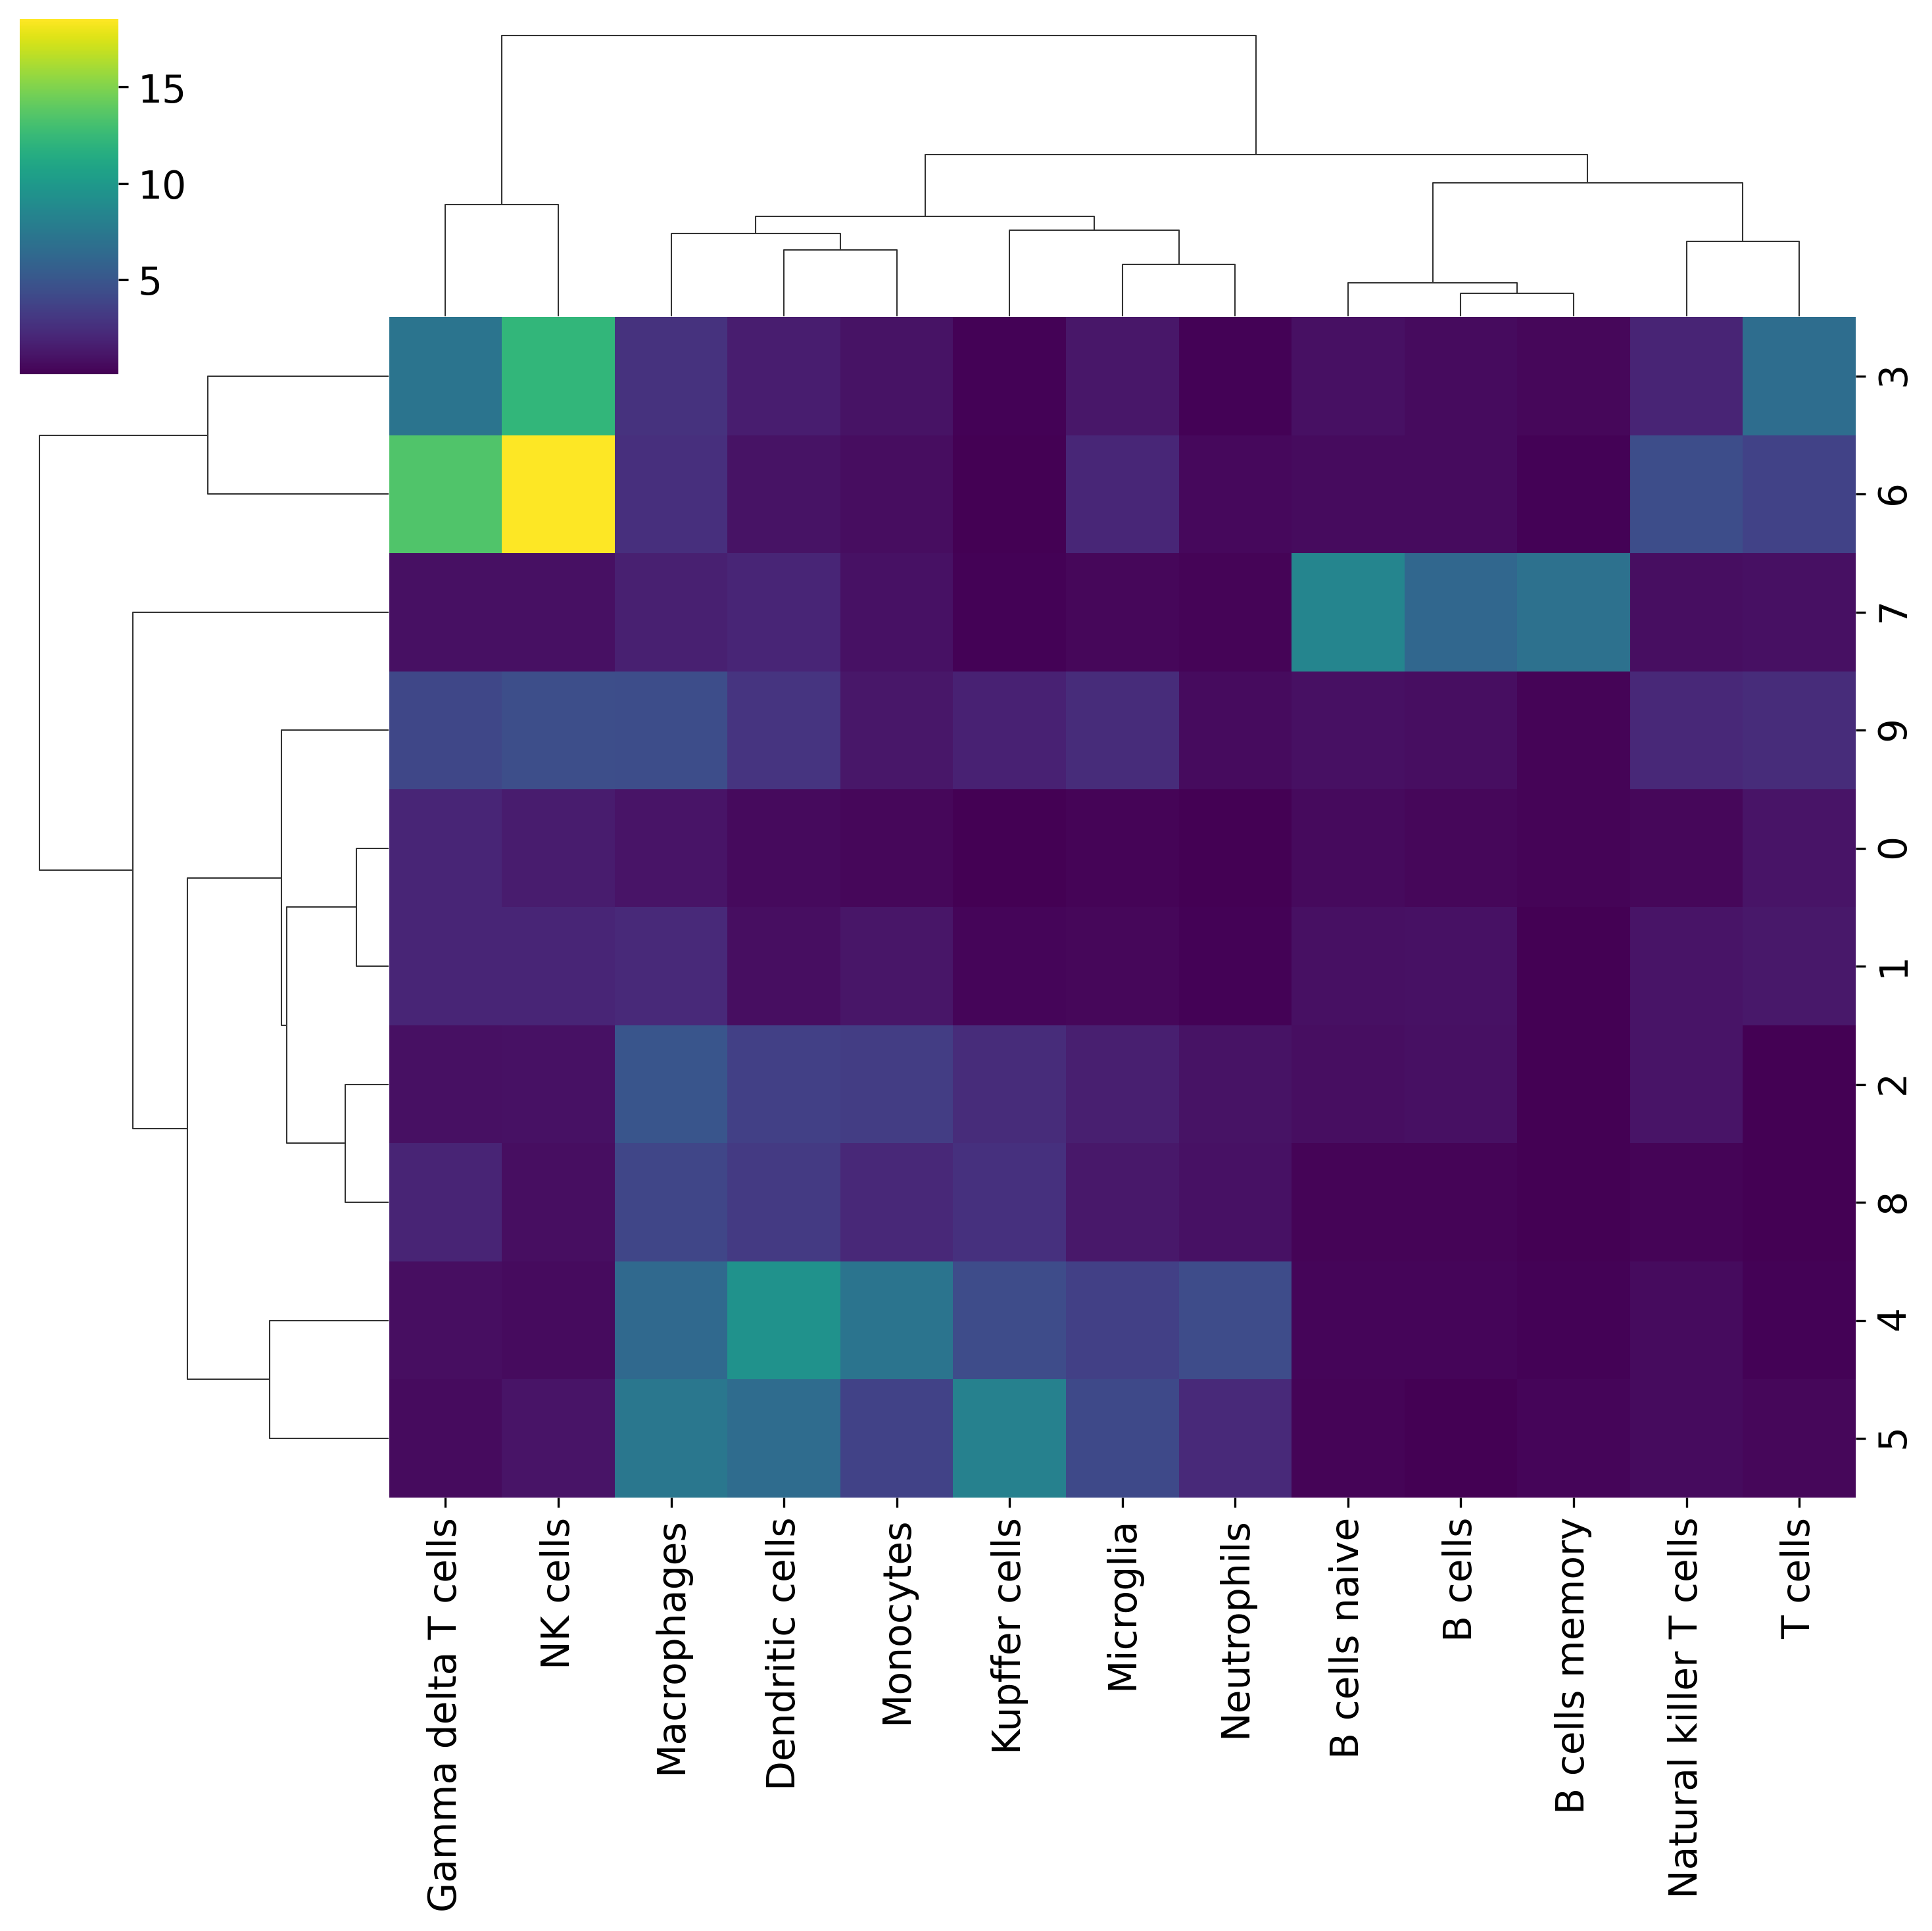

In [133]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [134]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Gamma delta T cells',
 '1': 'Macrophages',
 '2': 'Macrophages',
 '3': 'NK cells',
 '4': 'Dendritic cells',
 '5': 'Kupffer cells',
 '6': 'NK cells',
 '7': 'B cells naive',
 '8': 'Macrophages',
 '9': 'NK cells'}

... storing 'cell_type' as categorical


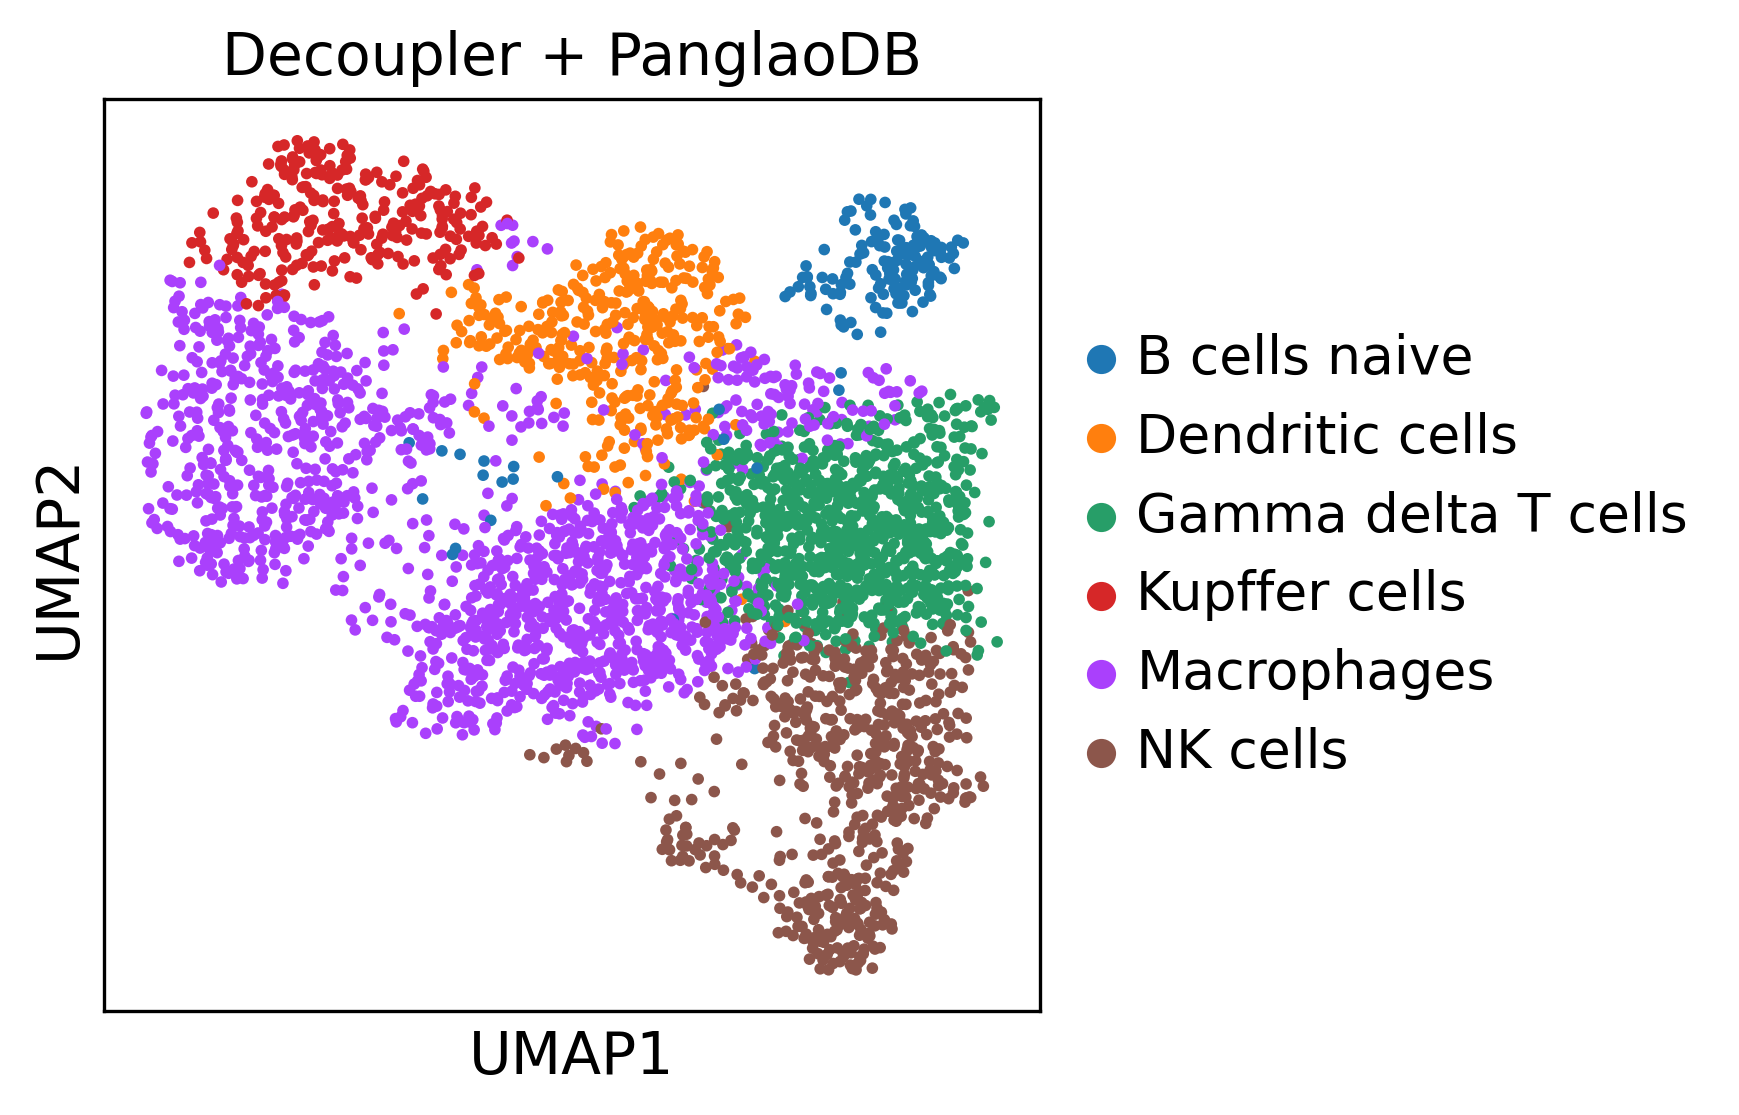

In [135]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [136]:
adata

AnnData object with n_obs × n_vars = 3848 × 5132
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors', 'cell_type_colors'


In [137]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_N_GSE147275_PMID34138753.h5ad")